In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

In [2]:
def calculate_accuracies(data, thresholds):
    metrics = []
    for threshold in thresholds:
        correct_predictions_jaccard = sum(1 for item in data if item["similarity_score_jaccard"] >= threshold)
        correct_predictions_cosine = sum(1 for item in data if item["similarity_score_cosine"] >= threshold)
        total_questions = len(data)
        metrics.append({
            'Threshold': threshold,
            'Jaccard Accuracy': correct_predictions_jaccard / total_questions,
            'Cosine Accuracy': correct_predictions_cosine / total_questions,
            'Total Correct Jaccard': correct_predictions_jaccard,
            'Total Correct Cosine': correct_predictions_cosine
        })
    return pd.DataFrame(metrics)

In [3]:
with open('predictions.json', 'r') as file:
    data_with_context = json.load(file)['data']
with open('predictions_gpt.json', 'r') as file:
    data_without_context = json.load(file)['data']

thresholds = np.arange(0.0, 1.0, 0.001)

df_metrics_with_context = calculate_accuracies(data_with_context, thresholds)
df_metrics_without_context = calculate_accuracies(data_without_context, thresholds)

median_jaccard_with_context = df_metrics_with_context['Jaccard Accuracy'].median()
median_jaccard_without_context = df_metrics_without_context['Jaccard Accuracy'].median()
median_cosine_with_context = df_metrics_with_context['Cosine Accuracy'].median()
median_cosine_without_context = df_metrics_without_context['Cosine Accuracy'].median()

In [4]:
def find_intersection(func1, func2, x_range):
    x = np.linspace(x_range[0], x_range[1], num=1000)
    f1 = interp1d(x, func1(x), kind='linear')
    f2 = interp1d(x, func2(x), kind='linear')
    diff = f1(x) - f2(x)
    idx = np.argwhere(np.diff(np.sign(diff))).flatten()
    return x[idx], f1(x[idx])

In [5]:
x_range = (thresholds[0], thresholds[-1])

In [6]:
intersection_jaccard, accuracy_jaccard = find_intersection(
    lambda x: np.interp(x, df_metrics_with_context['Threshold'], df_metrics_with_context['Jaccard Accuracy']),
    lambda x: np.interp(x, df_metrics_without_context['Threshold'], df_metrics_without_context['Jaccard Accuracy']),
    (thresholds[0], thresholds[-1])
)
intersection_cosine, accuracy_cosine = find_intersection(
    lambda x: np.interp(x, df_metrics_with_context['Threshold'], df_metrics_with_context['Cosine Accuracy']),
    lambda x: np.interp(x, df_metrics_without_context['Threshold'], df_metrics_without_context['Cosine Accuracy']),
    (thresholds[0], thresholds[-1])
)

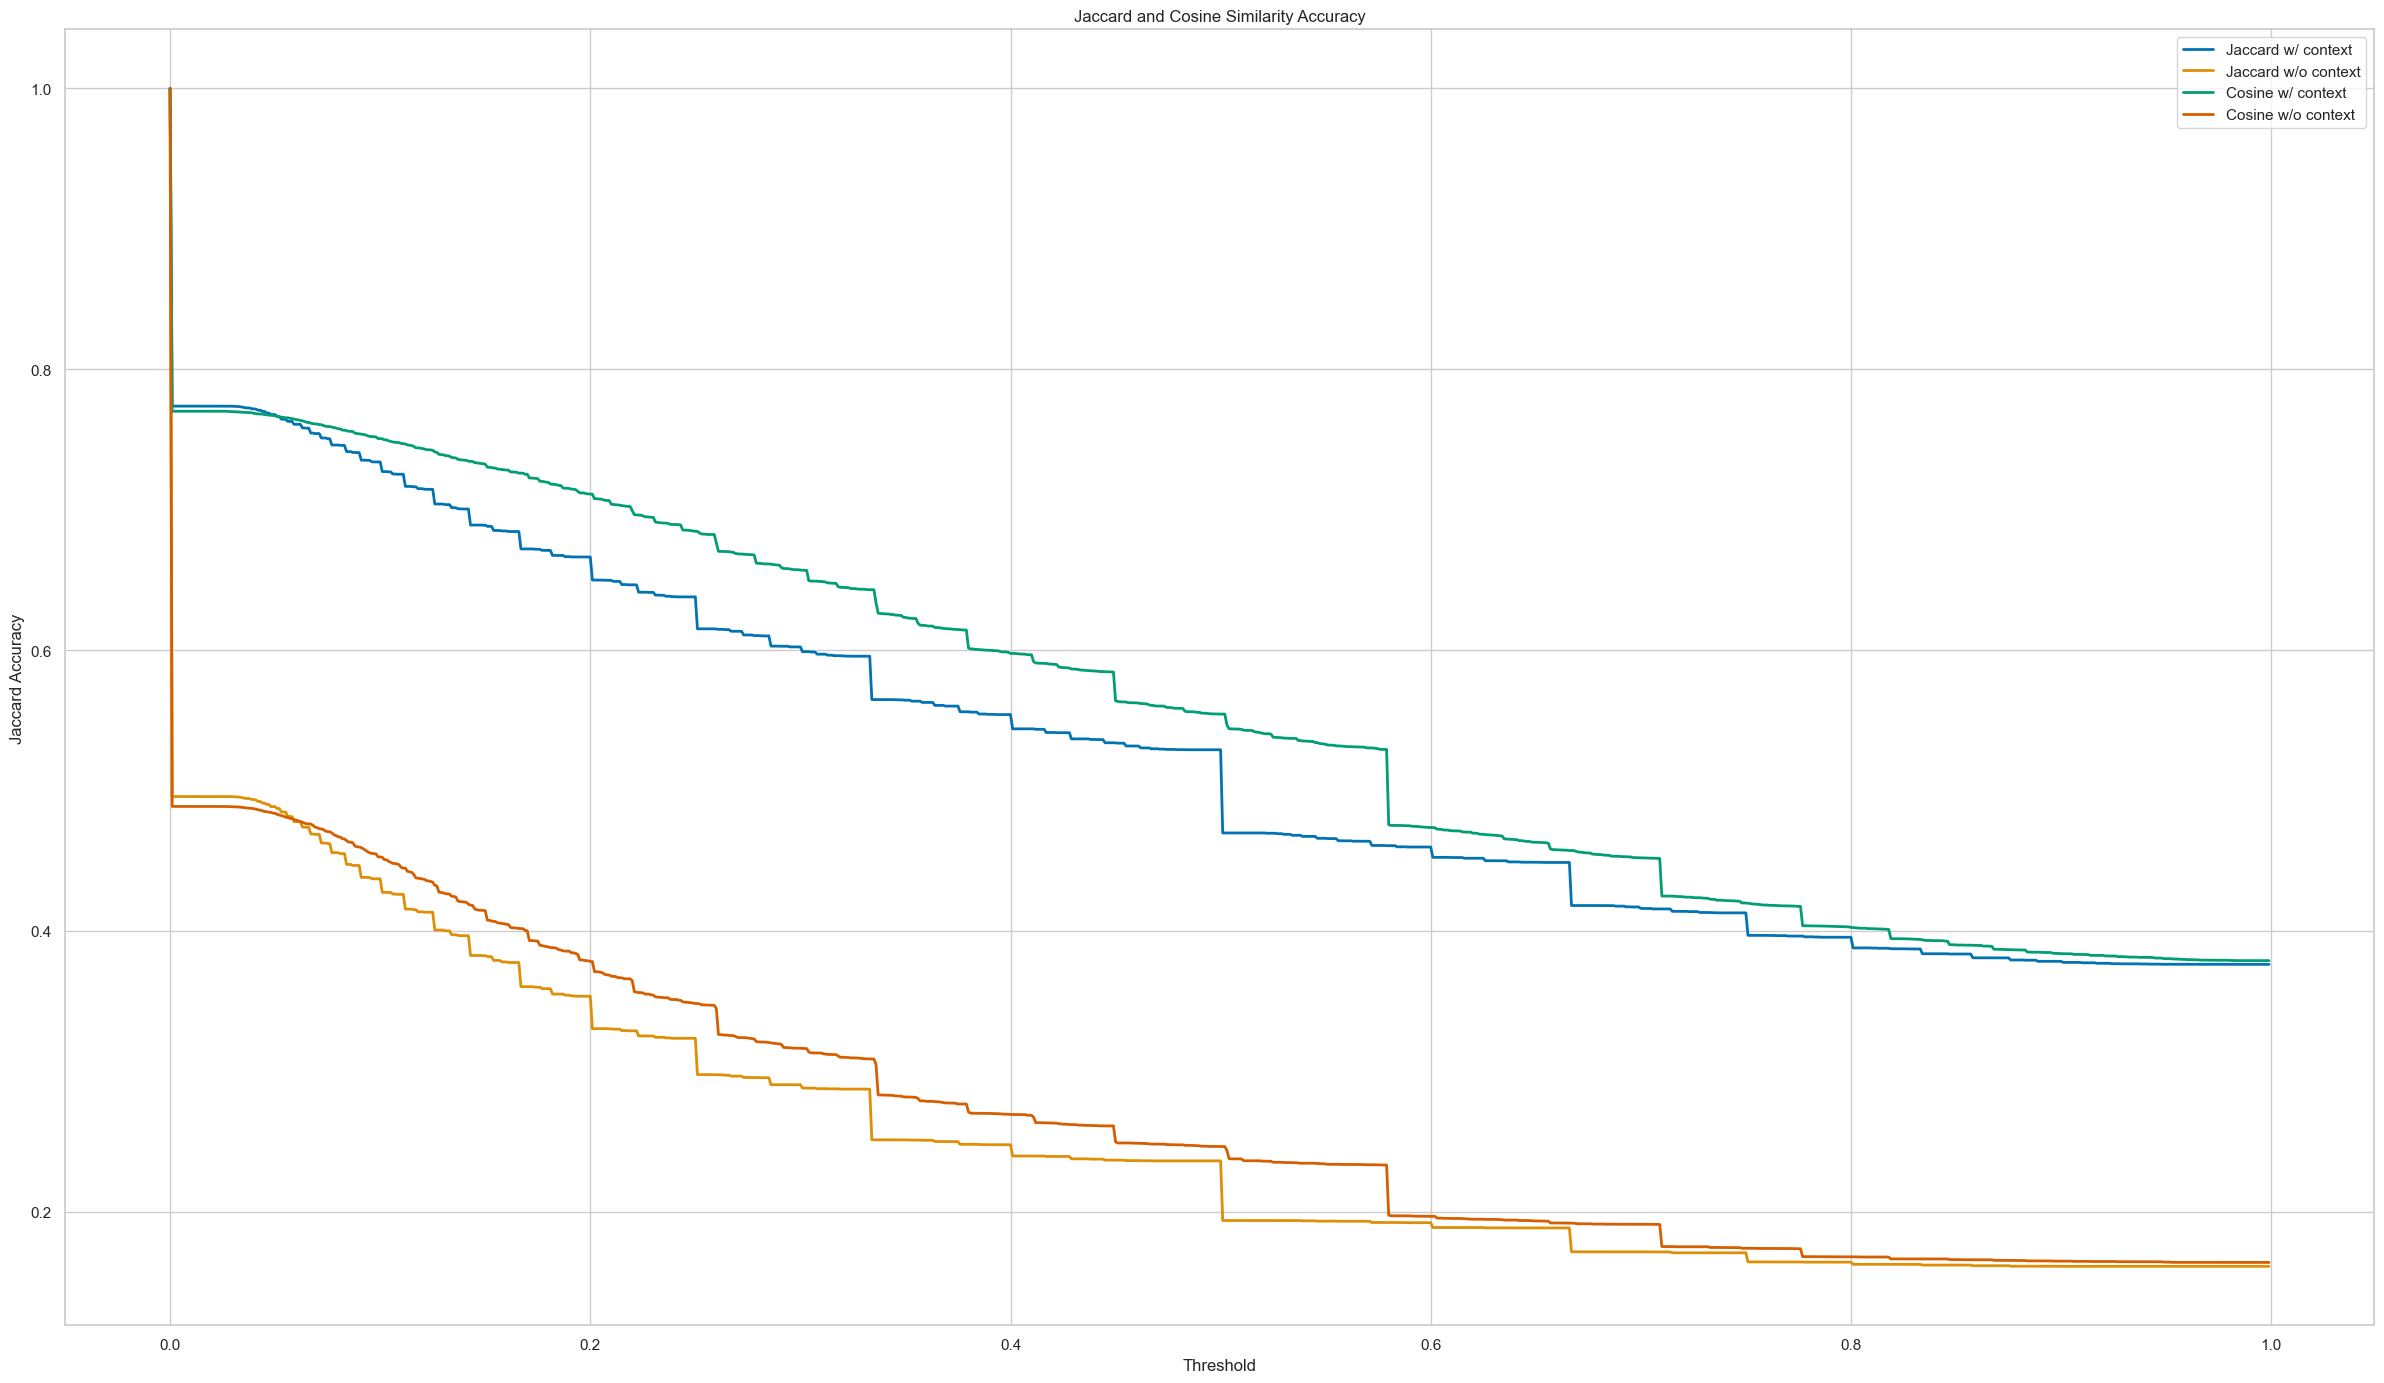

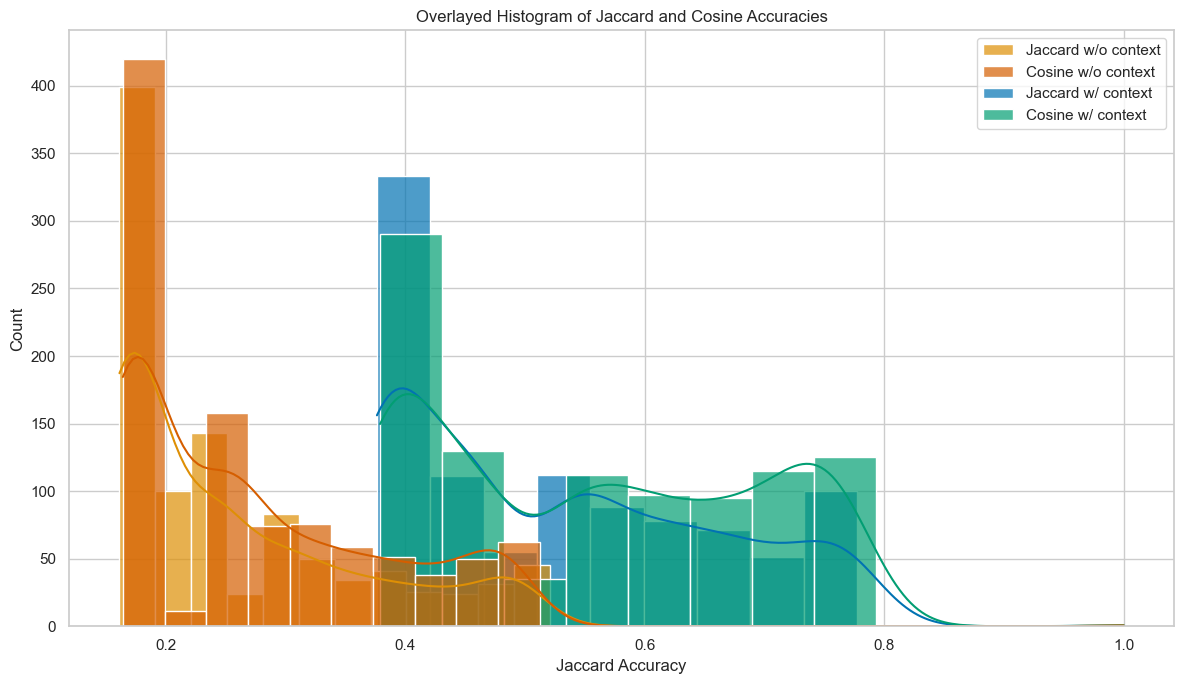

In [7]:
# Visualization setup
sns.set_theme(style="whitegrid")
palette = sns.color_palette("colorblind", as_cmap=False)
colors = [palette[i] for i in range(len(palette))]

# Line plot for Accuracy
fig, ax = plt.subplots(figsize=(24, 14))
sns.lineplot(x='Threshold', y='Jaccard Accuracy', data=df_metrics_with_context, label='Jaccard w/ context', color=colors[0], lw=2, ax=ax)
sns.lineplot(x='Threshold', y='Jaccard Accuracy', data=df_metrics_without_context, label='Jaccard w/o context', color=colors[1], lw=2, ax=ax)

sns.lineplot(x='Threshold', y='Cosine Accuracy', data=df_metrics_with_context, label='Cosine w/ context', color=colors[2], lw=2, ax=ax)
sns.lineplot(x='Threshold', y='Cosine Accuracy', data=df_metrics_without_context, label='Cosine w/o context', color=colors[3], lw=2, ax=ax)

handles, labels = ax.get_legend_handles_labels()

new_order = [1, 3, 0, 2]
handles = [handles[idx] for idx in new_order]
labels = [labels[idx] for idx in new_order]

ax.set_title('Jaccard and Cosine Similarity Accuracy')
ax.legend()

plt.tight_layout()
plt.savefig('plot.png', dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(12, 7))

# Histogram for Accuracy
sns.histplot(df_metrics_with_context, x='Jaccard Accuracy', color=palette[0], label='Jaccard w/ context', kde=True, alpha=0.7, ax=ax)
sns.histplot(df_metrics_without_context, x='Jaccard Accuracy', color=palette[1], label='Jaccard w/o context', kde=True, alpha=0.7, ax=ax)

sns.histplot(df_metrics_with_context, x='Cosine Accuracy', color=palette[2], label='Cosine w/ context', kde=True, alpha=0.7, ax=ax)
sns.histplot(df_metrics_without_context, x='Cosine Accuracy', color=palette[3], label='Cosine w/o context', kde=True, alpha=0.7, ax=ax)

handles, labels = ax.get_legend_handles_labels()

new_order = [1, 3, 0, 2]
handles = [handles[idx] for idx in new_order]
labels = [labels[idx] for idx in new_order]

ax.set_title('Overlayed Histogram of Jaccard and Cosine Accuracies')
ax.legend(handles, labels)

plt.tight_layout()
plt.savefig('histogram.png', dpi=300)
plt.show()

In [8]:
# Output a sample of the dataframe to verify the accuracy calculations
print(df_metrics_with_context[['Threshold', 'Jaccard Accuracy', 'Cosine Accuracy']].sample(10))
print(df_metrics_without_context[['Threshold', 'Jaccard Accuracy', 'Cosine Accuracy']].sample(10))

     Threshold  Jaccard Accuracy  Cosine Accuracy
750      0.750           0.41285          0.41985
660      0.660           0.44875          0.45780
975      0.975           0.37620          0.37910
369      0.369           0.56010          0.61530
517      0.517           0.46975          0.54155
176      0.176           0.67175          0.72020
213      0.213           0.64890          0.70330
609      0.609           0.45230          0.47150
435      0.435           0.53675          0.58565
657      0.657           0.44875          0.45835
     Threshold  Jaccard Accuracy  Cosine Accuracy
981      0.981           0.16115          0.16395
608      0.608           0.18880          0.19535
980      0.980           0.16115          0.16395
272      0.272           0.29660          0.32400
907      0.907           0.16115          0.16470
833      0.833           0.16255          0.16645
227      0.227           0.32525          0.35500
88       0.088           0.44660          0.46035


C:\Users\nneubacher10208\AppData\Local\Temp\ipykernel_20092\2735424715.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Jaccard w/ context', 'Cosine w/ context', 'Jaccard w/o context', 'Cosine w/o context'],
C:\Users\nneubacher10208\AppData\Local\Temp\ipykernel_20092\2735424715.py:12: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(x=['Jaccard w/ context', 'Cosine w/ context', 'Jaccard w/o context', 'Cosine w/o context'],


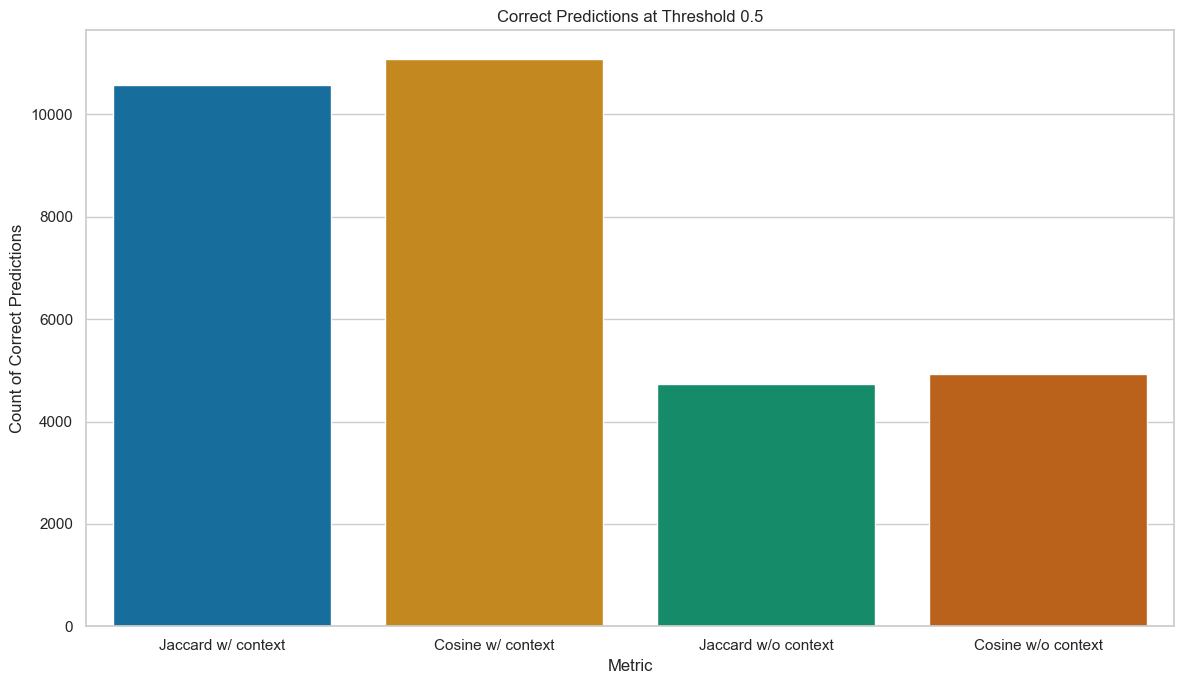

In [9]:
# Choose the threshold value you're interested in
specific_threshold = 0.5

# Filter the rows where the threshold is equal to the specific threshold
specific_df_with_context = df_metrics_with_context[df_metrics_with_context['Threshold'] == specific_threshold]
specific_df_without_context = df_metrics_without_context[df_metrics_without_context['Threshold'] == specific_threshold]

# Now plot histograms of the 'Total Correct Jaccard' and 'Total Correct Cosine' for that threshold
fig, ax = plt.subplots(figsize=(12, 7))

# You might want to use a bar plot if you are just showing the counts at a single threshold
sns.barplot(x=['Jaccard w/ context', 'Cosine w/ context', 'Jaccard w/o context', 'Cosine w/o context'],
            y=[
                specific_df_with_context['Total Correct Jaccard'].values[0], 
                specific_df_with_context['Total Correct Cosine'].values[0],
                specific_df_without_context['Total Correct Jaccard'].values[0], 
                specific_df_without_context['Total Correct Cosine'].values[0]
            ],
            palette=palette)

ax.set_title(f'Correct Predictions at Threshold {specific_threshold}')
ax.set_ylabel('Count of Correct Predictions')
ax.set_xlabel('Metric')

plt.tight_layout()
plt.savefig('correct_predictions_at_threshold.png', dpi=300)
plt.show()
